In [9]:
%autoreload 2 
%matplotlib ipympl

import numpy as np 
from pianoq.misc.mplt import mplot, mimshow
from pianoq.simulations.abstract_quantum_scaling.qwfs_simulation import QWFSSimulation
from pianoq.simulations.abstract_quantum_scaling.qwfs_result import QWFSResult
from pianoq.misc.mplc_writeup_imports import *

In [44]:
path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_11_26_16_55_09_qwfs_long_with_analytic.npz"
res = QWFSResult(path)

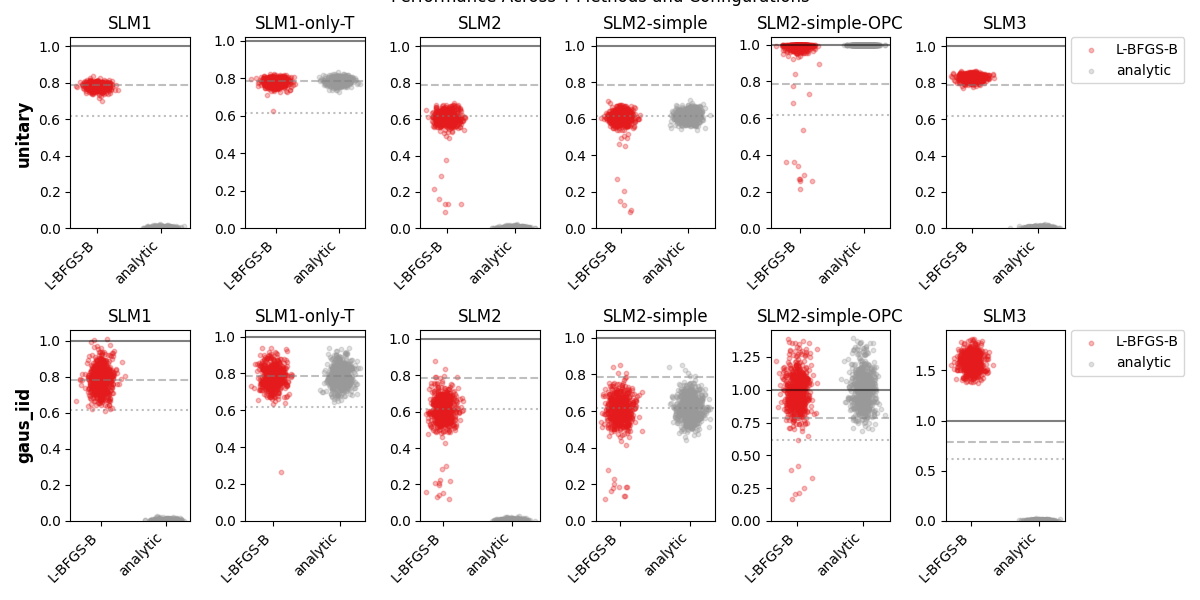

In [45]:
res.show_scatterplots()
plt.show(block=False)

In [12]:
res.print()

---- SLM1 ----
-- unitary --
L-BFGS-B                  0.782+-0.02
analytic                  0.004+-0.00
-- gaus_iid --
L-BFGS-B                  0.786+-0.07
analytic                  0.004+-0.00

---- SLM1-only-T ----
-- unitary --
L-BFGS-B                  0.781+-0.02
analytic                  0.786+-0.02
-- gaus_iid --
L-BFGS-B                  0.782+-0.06
analytic                  0.787+-0.05

---- SLM2 ----
-- unitary --
L-BFGS-B                  0.604+-0.06
analytic                  0.004+-0.00
-- gaus_iid --
L-BFGS-B                  0.604+-0.09
analytic                  0.004+-0.00

---- SLM2-simple ----
-- unitary --
L-BFGS-B                  0.606+-0.05
analytic                  0.617+-0.03
-- gaus_iid --
L-BFGS-B                  0.604+-0.09
analytic                  0.618+-0.06

---- SLM2-simple-OPC ----
-- unitary --
L-BFGS-B                  0.977+-0.09
analytic                  1.000+-0.00
-- gaus_iid --
L-BFGS-B                  0.986+-0.15
analytic                  1.0

And it seems that the simulation is all more or less OK:
* For SLM1 with and without the FFT etc. we get the $\pi / 4$, both analytically and with the nonlinear search. 
* Same for SLM2 configuration, and for OPC. 
* In both cases the spread of results is wider with the Gaussian IID than with unitary matrices, but this is expected. 
* The nonlinear search sometimes fails. 
* SLM3 is indeed $0.83 > \pi / 4$ for unitary, and $\approx 1.5$ for Gaussian IID, which is interesting! 

So basically now I can forget about all the SLM1,SLM2,OPC, since they all work and make sense, and only need to think better about the SLM3 configuration, why we get more than $\pi/4$ and why we get $1.5$! These are two questions with probably pretty different answers. The 0.83 might be the result of some mathematical reasoning. The 1.5 has something to do with energy harvesting somehow. We should look at the intensity distribution at different places to see what's what. 

## understand the 1.5

### optimizing energy on first pass, focus on second? 
First understanding: maybe the phases are optimizing two things: the gaus_iid matrux has a specific row with the most energy. So the phases will try to get as much energy at the crystal plane to the input of this row. It also tries to optimize the rest of the energy such as after coming back and fft etc. - it will focus. 

However - looking at the rows and cols of T - this doesn't seem quite right (highest energy in row is 1.3, not 2.7...). Also - playing with random phases and looking at output intensity shows that we are several standard deviations away. 

[Another wrong observation - the light at the crystal plane seems to have higher spikes, or a larger variance in internsity. 

No, this is wrong. It is just because lots of the energy is at the peak, so in general it is lower, by a relevant factor.]

### intensity at crystal plane   

interestingly, the total intensity at the crystal plane with the optimized phase is also already 1.6! And then it grows larger to 2.5. So these phases somehow grows the intensity in both trips, which is a little bit surprising.

### Further directions:
* Check how things vary with n_modes
* Check ow things vary with the sigma of the Gaussian IID
* Use other types of random matrices (CUE, a aspecial kind of extra-random unistary) 

## understand the 0.83

In [ ]:
pass

## Vary N

I tried to see how these results vary with the dimension of the matrix. I also checked wether a different kind of random unitary creation will make a difference. As I expected - it didn't. But the dependence on N seems small, but existent. 

In [92]:
plt.close('all')
import re 
def get_Ns_ress(glob_regex):
    paths = glob.glob(glob_regex)
    ress = [QWFSResult(path) for path in paths]
    Ns = np.array([re.findall('.*N=(\d+)_.*', path)[0] for path in paths]).astype(float)
    return Ns, ress

def show_N_dependance(Ns, ress, full_std=False):
    T_methods = ress[0].T_methods
    fig, ax = plt.subplots()
    
    for T_method_no, T_method in enumerate(T_methods):
        effs = np.zeros_like(Ns)
        eff_stds = np.zeros_like(Ns)
        
        for i, N in enumerate(Ns):
            res = ress[i]
            config_no = list(res.configs).index('SLM3')
            algo_no = list(res.algos).index('L-BFGS-B')
            effs[i] = res.results[T_method_no, config_no].mean(axis=0)[algo_no]
            eff_stds[i] = res.results[T_method_no, config_no].std(axis=0)[algo_no]
        
        y_err = eff_stds
        if not full_std:
            y_err /= res.results.shape[2]
        ax.errorbar(Ns, effs, yerr=y_err, label=T_method, marker='o')
        # ax.errorbar(Ns, effs, yerr=eff_stds2, alpha=0.7, marker='o')
    ax.legend()    

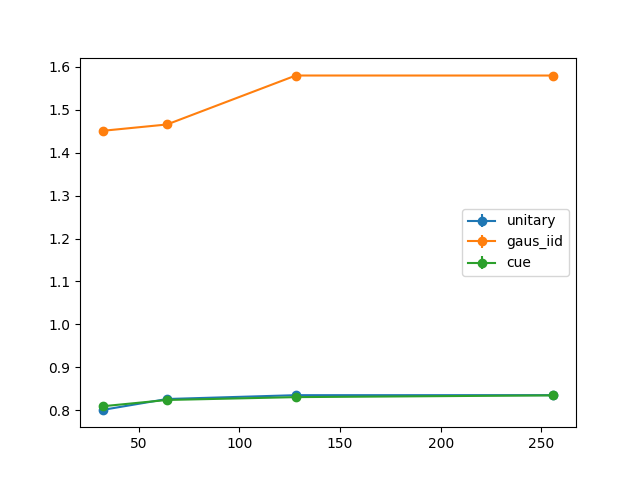

In [89]:
glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_11_28_14*N=*.npz'
Ns, ress = get_Ns_ress(glob_regex)
show_N_dependance(Ns, ress, full_std=False)

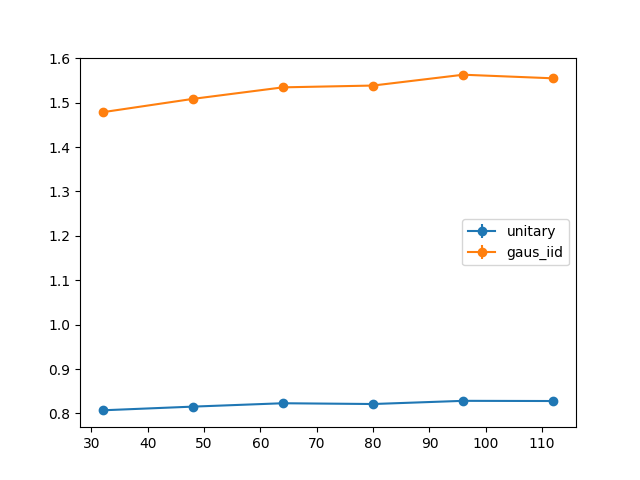

In [95]:
glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_11_28_15*N=*.npz'
Ns, ress = get_Ns_ress(glob_regex)
show_N_dependance(Ns, ress, full_std=False)

In [40]:
for res in ress:
    print(f'---{res.N_modes=}---')
    # res.show_scatterplots()
    # plt.show(block=False)
    res.print(only_slm3=True)

50